In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
import torchvision
from torchvision import datasets, transforms
import torchvision.models as tv_models

In [2]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd
#%%
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label
#%%
def get_dataloader(path='/Users/andersen/Downloads/hw5s/S224'):
    df_train=pd.read_csv(path+'/train.csv')
    df_val=pd.read_csv(path+'/val.csv')
    df_test=pd.read_csv(path+'/test.csv')
    print("Train file paths:", df_train['filename'].values)
    print("Val file paths:", df_val['filename'].values)
    print("Test file paths:", df_test['filename'].values)
    dataset_train = MyDataset(path+'/', df_train['filename'].values, df_train['label'].values)
    dataset_val = MyDataset(path+'/', df_val['filename'].values, df_val['label'].values)
    dataset_test = MyDataset(path+'/', df_test['filename'].values, df_test['label'].values)
    loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
    loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0,
                                  shuffle=False, pin_memory=True)
    loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0,
                                   shuffle=True, pin_memory=True)
	#modify this function to return loader_train, loader_val, and loader_test
    # is num_workers same for train, val, and test? shuffle Test??
    return loader_train, loader_val, loader_test
def get_datasets(path='/Users/andersen/Downloads/hw5s/S224'):
    df_train=pd.read_csv(path+'/train.csv')
    df_val=pd.read_csv(path+'/val.csv')
    df_test=pd.read_csv(path+'/test.csv')
    dataset_train = MyDataset(path+'/', df_train['filename'].values, df_train['label'].values)
    dataset_val = MyDataset(path+'/', df_val['filename'].values, df_val['label'].values)
    dataset_test = MyDataset(path+'/', df_test['filename'].values, df_test['label'].values)
    return dataset_train, dataset_val, dataset_test


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dataset_train, dataset_val, dataset_test = get_datasets()
loader_train, loader_val, loader_test = get_dataloader()

Train file paths: ['NORMAL/Non-Covid (1014).png' 'NORMAL/Non-Covid (2).png'
 'NORMAL/Non-Covid (311).png' ... 'COVID/Covid (959).png'
 'COVID/Covid (196).png' 'COVID/Covid (6).png']
Val file paths: ['NORMAL/Non-Covid (1198).png' 'NORMAL/Non-Covid (954).png'
 'NORMAL/Non-Covid (113).png' 'NORMAL/Non-Covid (151).png'
 'NORMAL/Non-Covid (57).png' 'NORMAL/Non-Covid (1024).png'
 'NORMAL/Non-Covid (61).png' 'NORMAL/Non-Covid (1100).png'
 'NORMAL/Non-Covid (614).png' 'NORMAL/Non-Covid (349).png'
 'NORMAL/Non-Covid (676).png' 'NORMAL/Non-Covid (878).png'
 'NORMAL/Non-Covid (984).png' 'NORMAL/Non-Covid (1157).png'
 'NORMAL/Non-Covid (615).png' 'NORMAL/Non-Covid (688).png'
 'NORMAL/Non-Covid (115).png' 'NORMAL/Non-Covid (203).png'
 'NORMAL/Non-Covid (23).png' 'NORMAL/Non-Covid (845).png'
 'NORMAL/Non-Covid (918).png' 'NORMAL/Non-Covid (903).png'
 'NORMAL/Non-Covid (1114).png' 'NORMAL/Non-Covid (1169).png'
 'NORMAL/Non-Covid (1120).png' 'NORMAL/Non-Covid (697).png'
 'NORMAL/Non-Covid (1176).png' 

In [4]:
print(f'dataset_train: {len(dataset_train)}, loader_train: {len(loader_train)}')
print(f'dataset_val: {len(dataset_val)}, loader_val: {len(loader_val)}')

dataset_train: 2022, loader_train: 64
dataset_val: 60, loader_val: 2


In [5]:
(x, label) = dataset_train[0]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
tensor(0)


/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


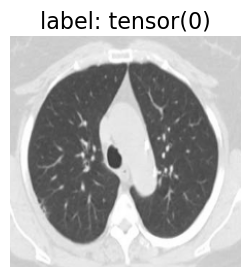

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 10, 1):
    x = dataset_train[n][0].detach().cpu().numpy()
    y = dataset_train[n][1]
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title('label: ' + str(y), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(0.5)  

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        #use resnet50 as the base model
        self.resnet50 = tv_models.resnet50()
        #modified the last layer for binary classification  
        self.resnet50.fc=torch.nn.Linear(2048, 1)          
    
    def forward(self,x):
        z = self.resnet50(x)
        z = z.view(-1)
        return z

In [8]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [9]:
tv_models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# The function to train the model in one epoch
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

In [11]:
# The function to test the model
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

In [12]:
# Create the model and start the training-validation process
# training the CNN from Scratch
# !pip install torch==<desired_version>+cpu torchvision==<desired_version> -f https://download.pytorch.org/whl/opencl.html
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=Net()
model.to(device)
#optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99) 
#---------------------------------------------------------
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
label=label.to(device)
z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cpu


/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


In [13]:
z

tensor([0.3295], grad_fn=<ViewBackward0>)

In [14]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.5816], grad_fn=<SigmoidBackward0>)

In [15]:
z.shape

torch.Size([1])

In [16]:
# plot the result
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [17]:
#update learning reate
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

# 2D CNN Model from Scratch

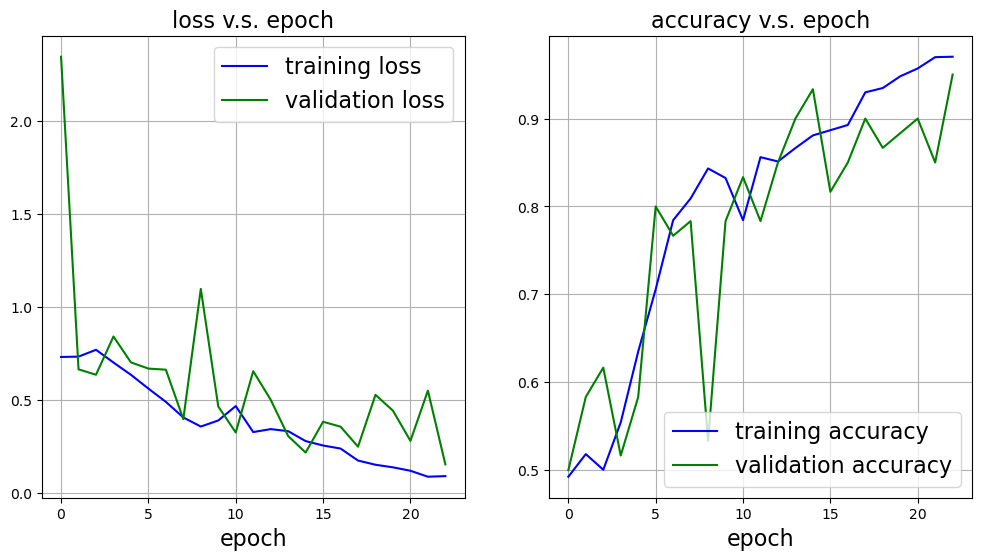

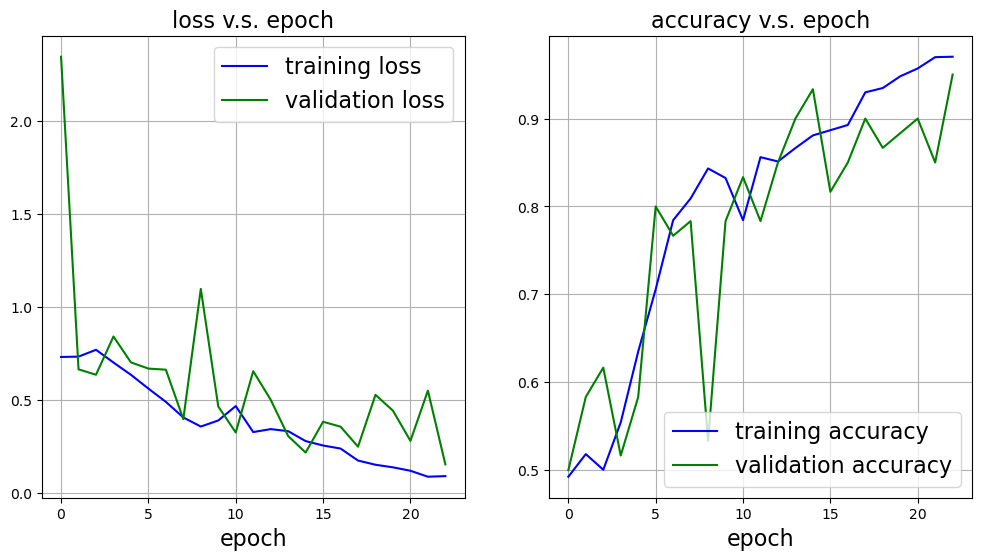

In [18]:
for epoch in range(epoch_save+1, 23):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    t1=time.time()
    print("time cost", t1-t0)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_LS_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss v.s. epoch'}, xlabel='epoch'>,
        <AxesSubplot:title={'center':'accuracy v.s. epoch'}, xlabel='epoch'>],
       dtype=object))

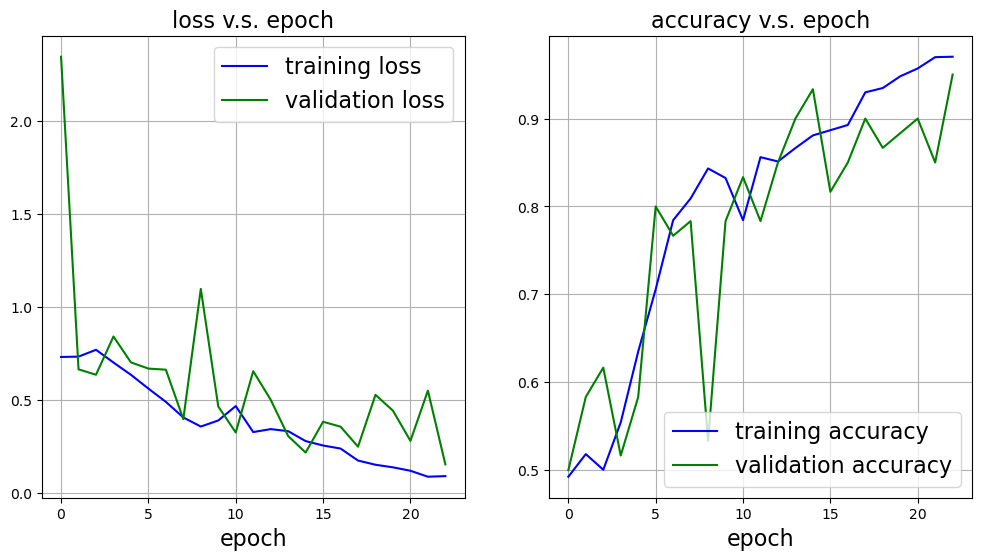

In [19]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list)

In [20]:
# load the best model
best_id= np.array(acc_val_list).argmax()
best_id

22

In [21]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_LS_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']  

In [22]:
loss_test, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Accuracy (average) 0.905
Accuracy (average) 0.905
Sensitivity [0.95 0.86]
Precision [0.87155963 0.94505495]
Confusion_sens 
 [[0.95 0.05]
 [0.14 0.86]]
Confusion_prec 
 [[0.87155963 0.05494505]
 [0.12844037 0.94505495]]


In [23]:
# Train CNN using transfer learning
# DataLoaders
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dataset_train, dataset_val, dataset_test = get_datasets()
loader_train, loader_val, loader_test = get_dataloader()

Train file paths: ['NORMAL/Non-Covid (1014).png' 'NORMAL/Non-Covid (2).png'
 'NORMAL/Non-Covid (311).png' ... 'COVID/Covid (959).png'
 'COVID/Covid (196).png' 'COVID/Covid (6).png']
Val file paths: ['NORMAL/Non-Covid (1198).png' 'NORMAL/Non-Covid (954).png'
 'NORMAL/Non-Covid (113).png' 'NORMAL/Non-Covid (151).png'
 'NORMAL/Non-Covid (57).png' 'NORMAL/Non-Covid (1024).png'
 'NORMAL/Non-Covid (61).png' 'NORMAL/Non-Covid (1100).png'
 'NORMAL/Non-Covid (614).png' 'NORMAL/Non-Covid (349).png'
 'NORMAL/Non-Covid (676).png' 'NORMAL/Non-Covid (878).png'
 'NORMAL/Non-Covid (984).png' 'NORMAL/Non-Covid (1157).png'
 'NORMAL/Non-Covid (615).png' 'NORMAL/Non-Covid (688).png'
 'NORMAL/Non-Covid (115).png' 'NORMAL/Non-Covid (203).png'
 'NORMAL/Non-Covid (23).png' 'NORMAL/Non-Covid (845).png'
 'NORMAL/Non-Covid (918).png' 'NORMAL/Non-Covid (903).png'
 'NORMAL/Non-Covid (1114).png' 'NORMAL/Non-Covid (1169).png'
 'NORMAL/Non-Covid (1120).png' 'NORMAL/Non-Covid (697).png'
 'NORMAL/Non-Covid (1176).png' 

In [24]:
print(f'dataset_train: {len(dataset_train)}, loader_train: {len(loader_train)}')
print(f'dataset_val: {len(dataset_val)}, loader_val: {len(loader_val)}')

dataset_train: 2022, loader_train: 64
dataset_val: 60, loader_val: 2


In [25]:
(x, label)=dataset_train[0]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
tensor(0)


/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


In [26]:
(x, label)=dataset_train[1000]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
tensor(1)


/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


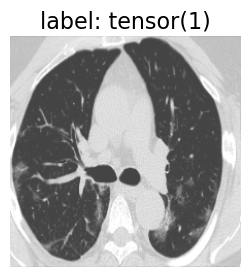

In [27]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 1100, 100):
    x = dataset_train[n][0].detach().cpu().numpy()
    y = dataset_train[n][1]
    x = x.transpose(1, 2, 0)
    ax.imshow(x)
    ax.set_title('label: ' + str(y), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(0.5)

In [28]:
from torchvision.models import ResNet50_Weights
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        #use resnet50 as the base model
        #self.resnet50 = tv_models.resnet50(pretrained=True) #old Pytorch
        self.resnet50 = tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #modified the last layer for binary classification  
        self.resnet50.fc=torch.nn.Linear(2048, 1)           
        #freeze all parameters
        for p in self.resnet50.parameters():
            p.requires_grad = False 
        #set the parameters of layer4 to be trainable       
        for p in self.resnet50.layer4.parameters():
            p.requires_grad = True       
        #set the parameters of fc to be trainable       
        for p in self.resnet50.fc.parameters():
            p.requires_grad = True       
        
    def get_trainable_parameters(self):
        pList=list(self.resnet50.layer4.parameters())+list(self.resnet50.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet50(x)
        z = z.view(-1)
        return z

In [29]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [30]:
tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        print(X.shape, Y.shape)
        print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

In [32]:
def test(model, device, dataloader):
    model.eval()
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): 
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() 
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=Net()
model.to(device)
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cpu


/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


In [34]:
z

tensor([-0.0622], grad_fn=<ViewBackward0>)

In [35]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.4845], grad_fn=<SigmoidBackward0>)

In [36]:
z.shape

torch.Size([1])

In [37]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [38]:
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

# 2D CNN using Transfer Learning

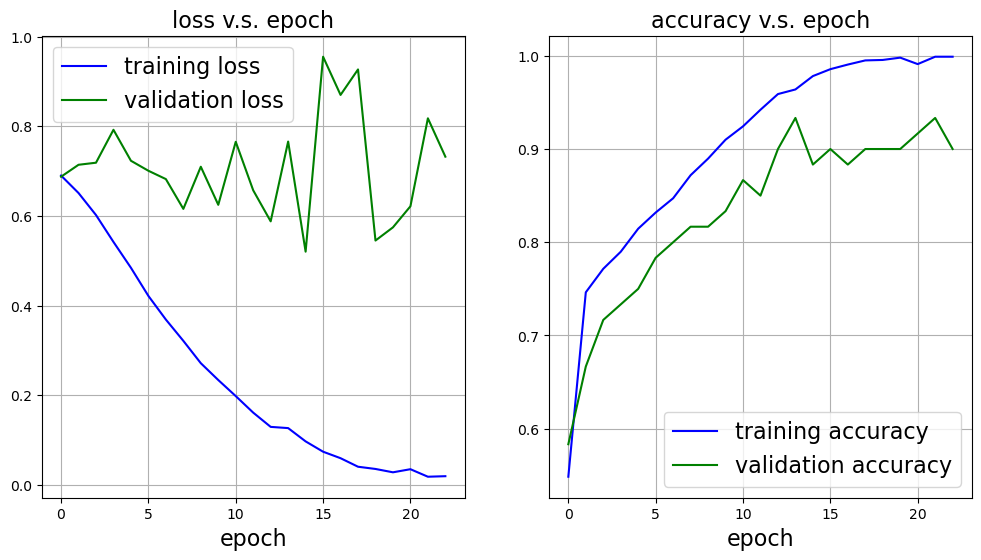

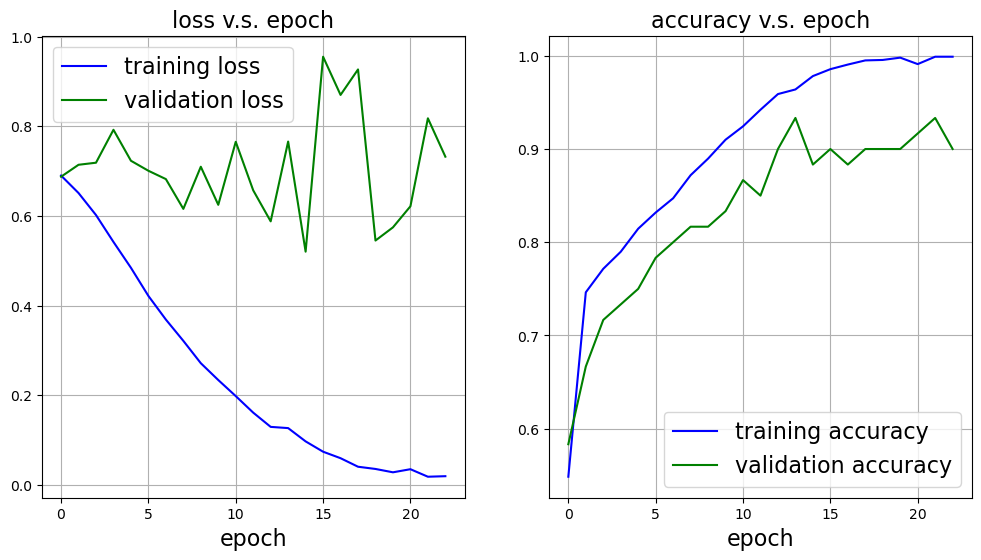

In [39]:
for epoch in range(epoch_save+1, 23):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    t1=time.time()
    print("time cost", t1-t0)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_TL_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

(<Figure size 1200x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss v.s. epoch'}, xlabel='epoch'>,
        <AxesSubplot:title={'center':'accuracy v.s. epoch'}, xlabel='epoch'>],
       dtype=object))

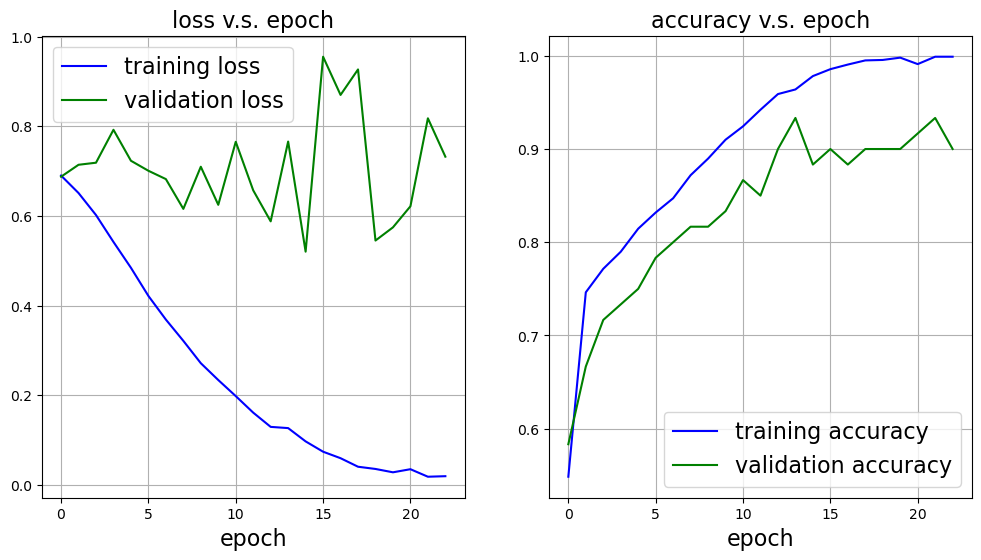

In [40]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list)

In [41]:
best_id= np.array(acc_val_list).argmax()
best_id

13

In [42]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_TL_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']  

In [43]:
loss_test, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

/var/folders/7m/m8y5x3654vsfvdr5zmpdl5v40000gn/T/ipykernel_80088/2989346994.py:25: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label=torch.tensor(self.labellist[idx], dtype=torch.int64)


Accuracy (average) 0.9125
Accuracy (average) 0.9125
Sensitivity [0.89  0.935]
Precision [0.93193717 0.89473684]
Confusion_sens 
 [[0.89  0.11 ]
 [0.065 0.935]]
Confusion_prec 
 [[0.93193717 0.10526316]
 [0.06806283 0.89473684]]


# scratch vs transfer learning 

In [44]:
print('2D CNN using transfer learning performed better than from scratch')
print(f'2D CNN (transfer learning) accuracy (average) {acc_test}')
print(f'2D CNN (from scratch) accuracy (average) 0.925')

2D CNN using transfer learning performed better than from scratch
2D CNN (transfer learning) accuracy (average) 0.9125
2D CNN (from scratch) accuracy (average) 0.925


# Using CAM Methods to visualize models

In [46]:
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import torch
import matplotlib.pyplot as plt
import skimage

In [47]:

model.eval()
model

Net(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [50]:
#choose the target layer(s)
target_layers = [model.resnet50.layer4[-1]]

In [49]:
print(model)


Net(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

(224, 224, 3)


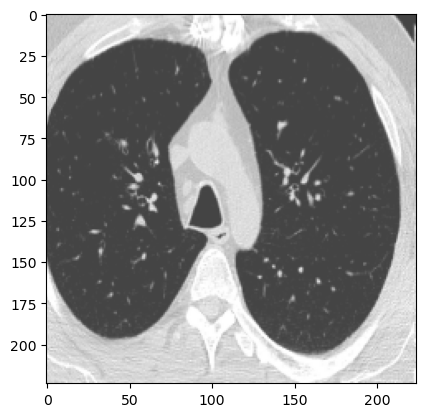

In [74]:

image=skimage.io.imread('/Users/andersen/Downloads/hw5s/S224/COVID/Covid (100).png')

image=image.astype("float32")
image=image/image.max()
image=np.stack([image]*3, axis=-1)
image.shape
print(image.shape)
plt.imshow(image)

In [75]:
#convert numpy array to pytorch tensor
image_input=torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

torch.Size([1, 3, 224, 224])

In [76]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [77]:
model_output=model(image_input)
model_output.shape

print(model_output.shape)

torch.Size([1])


In [78]:
def custom_target(model_output):
    # Assuming model_output is a scalar
    return model_output

grayscale_cam = cam(input_tensor=image_input, 
                    targets=[custom_target], 
                    aug_smooth=True, 
                    eigen_smooth=True)

In [79]:
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
#category 281 is tabby, tabby cat



# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# pay attention to the shape of each input

grayscale_cam.shape

(1, 224, 224)

In [80]:
grayscale_cam=grayscale_cam[0]
grayscale_cam.shape

(224, 224)

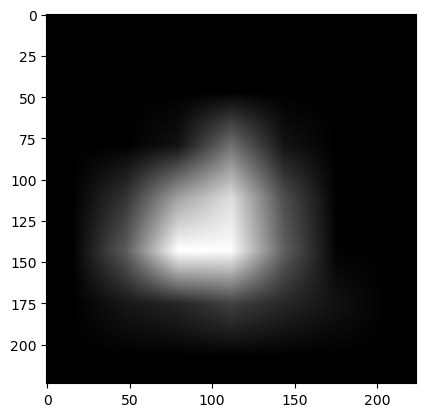

In [81]:
plt.imshow(grayscale_cam, cmap='gray')

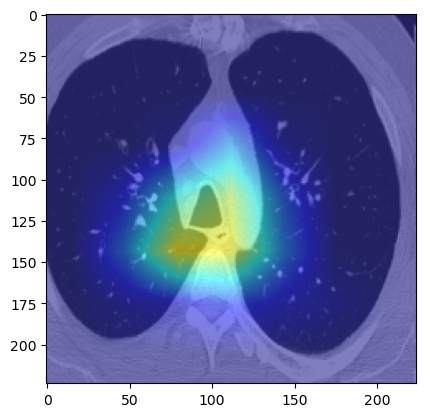

In [82]:
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)

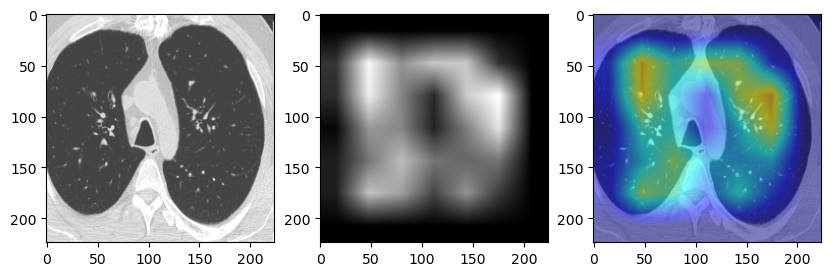

In [83]:
#GradCAM

def custom_target(model_output):
    # Assuming model_output is a scalar
    return model_output

grayscale_cam = cam(input_tensor=image_input, 
                    targets=[custom_target], 
                    aug_smooth=True, 
                    eigen_smooth=True)


cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
#grayscale_cam = cam(input_tensor=image_input, targets=None, aug_smooth=True, eigen_smooth=True)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

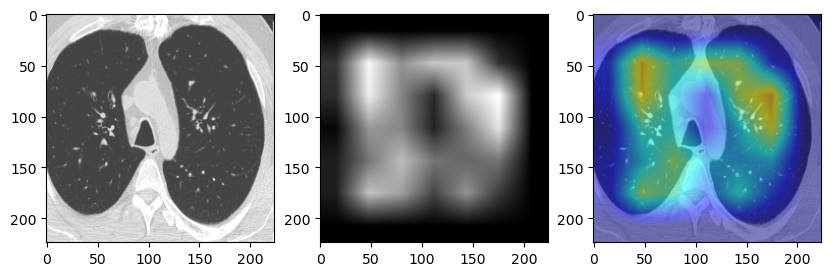

In [84]:
#EigenCAM
def custom_target(model_output):
    # Assuming model_output is a scalar
    return model_output

grayscale_cam = cam(input_tensor=image_input, 
                    targets=[custom_target], 
                    aug_smooth=True, 
                    eigen_smooth=True)

cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)